In [1]:
import os
import sys
import pandas as pd
import csv
from datetime import datetime
from tqdm import tqdm
import time

### python package used to open excel workbook and modify it
#!{sys.executable} -m pip install openpyxl

### another excel/python package that seems to be better
### this package allows you to open excel, modify a value, and view what that modified value is
!{sys.executable} -m pip install xlwings

import xlwings as xw
print('Loaded Libraries')


Loaded Libraries


In [2]:
from itertools import product

#Hazards
climate = ["access-cm2_r5i1p1f1_ssp370", "canesm5_r1i1p2f1_ssp370", "cesm2_r11i1p1f1_ssp370", "cnrm-esm2-1_r1i1p1f2_ssp370", "ec-earth3_r1i1p1f1_ssp370", "ec-earth3-veg_r1i1p1f1_ssp370", "miroc6_r1i1p1f1_ssp370", "mpi-esm1-2-hr_r7i1p1f1_ssp370", "noresm2-mm_r1i1p1f1_ssp370", "taiesm1_r1i1p1f1_ssp370"]
EQ = [0]

#Exogenous/Scenarios
compact = ["Existing Policy", "AA1-2024", "AA1-2025", "AA2-2024", "AA2-2025"]
mwdcostr = ['0.0245','0.0319', '0.0391']
mwd_threshold_options=['373623']
pwsc_options=['IPR+DPR','None']
mwd_prop_ladwp_options=['0.17512']

#Endogenous/Strategies 
engineering_options = ["IPR Max Yield", "IPR Reduced Yield", "DPR Max Yield", "DPR Reduced Yield", "Hybrid (Current)", "Hybrid (No MWD)"]
disc_options= ['0.01','0.025','0.055']
spreading_inc_rate_options=['0']
gw_pumping_inc_rate_options=['0']
cons_options=['1','2','3']
addcons_options=['0']

#Overrun
overrun_options=['1','1.5','2']

Scenarios = list(product(climate, EQ, compact, mwdcostr, mwd_threshold_options, pwsc_options, mwd_prop_ladwp_options, engineering_options, disc_options, spreading_inc_rate_options, gw_pumping_inc_rate_options, cons_options, addcons_options,overrun_options))


# Write to CSV
with open('all_opnext_scenario_inputs.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header
    header = ["index", "climate", "EQ", "compact", "mwdcostr", "mwdthresh", "pwsc", "mwdprop", "engineering", "disc", "spreading_inc_rate", "gw_pumping_inc_rate", "cons", "addcons", "overrun"]
    csv_writer.writerow(header)

    # Write data with numerical index
    for idx, scenario in enumerate(Scenarios):
        row = [idx] + list(scenario)
        csv_writer.writerow(row)

#Creating hash values for scenarios
input_df=pd.read_csv('all_opnext_scenario_inputs.csv')
input_df["uniquehash"]=input_df.apply(lambda row: hash(tuple(row)), axis=1)
input_df.to_csv('all_opnext_scenario_inputs.csv')
num_rows_len = len(input_df)
print(num_rows_len)
print(input_df.loc[:5])

print("CSV file created successfully.")

48600
   index                     climate  EQ          compact  mwdcostr  \
0      0  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   
1      1  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   
2      2  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   
3      3  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   
4      4  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   
5      5  access-cm2_r5i1p1f1_ssp370   0  Existing Policy    0.0245   

   mwdthresh     pwsc  mwdprop    engineering  disc  spreading_inc_rate  \
0     373623  IPR+DPR  0.17512  IPR Max Yield  0.01                   0   
1     373623  IPR+DPR  0.17512  IPR Max Yield  0.01                   0   
2     373623  IPR+DPR  0.17512  IPR Max Yield  0.01                   0   
3     373623  IPR+DPR  0.17512  IPR Max Yield  0.01                   0   
4     373623  IPR+DPR  0.17512  IPR Max Yield  0.01                   0   
5     373623  IPR+DPR  0.17512  IPR Max Yield 

In [38]:
import os
import pandas as pd
import csv
from datetime import datetime
from tqdm import tqdm

# Read in scenario inputs 
df = pd.read_csv('all_opnext_scenario_inputs.csv')

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024_A.csv'

# Check output csv for already completed 
# Check if the output CSV file already exists
if os.path.exists(output_csv_path):
    output_df = pd.read_csv(output_csv_path)
    output_df=output_df.reindex(df.index)
    processed_row_mask = output_df["uniquehash"].isin(df["uniquehash"])
    inputs_still_to_process = df[~processed_row_mask]
    iter_remaining = len(inputs_still_to_process)
    print (f"Rows remaining to process: {iter_remaining}")

else:
    inputs_still_to_process = df
    iter_remaining = len(inputs_still_to_process)
    print ("Rows remaining to process: ALL ")

#Locating file and noting which sheet to change
home_path = '/Users/profcalculus/Desktop/Ox/LCI/LADWP/OpNEXT Report Writing/Model Components/AC Model'
excel = os.path.join(home_path, '24.03.04-Operation NEXT AC Model_python.xlsx')

# Load Excel workbook
wb = xw.Book(excel)
sheet_ana = wb.sheets['Analysis Home']
sheet_wNEXT = wb.sheets['AC-Master w NEXT']
sheet_woNEXT = wb.sheets['AC-Master wo NEXT']

#Defining the output outcome headers, outcome values, and key variable headers
outputs=[]
output_values = "I5:Z5"
value_headers=sheet_ana["I3:Z3"].value
#outputs_headers = [['index','climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun','uniquehash'] + value_headers]
outputs=[]

#Locating cells for key variables and each cell's possible variable values to evaluate. Key variables conceptually split between hazards, strategies, and scenarios
#Hazards (Key hazard model variables that beyond any institutions' control)
climate_cell = "C9"
EQ_timing_cell = "C11"
#Scenarios (Key model policy variables that are exogenous to LADWP)
cra_compact_cell="C10"
mwd_costr_cell='C25'
mwd_threshold_cell='C39'
pwsc_cell='C20'
mwd_prop_ladwp_cell='C58'
#Strategies (Key model variables that are endogenous to LADWP)
engineering_cell = "C18"
disc_cell='C24'
spreading_inc_rate_cell='C45'
gw_pumping_inc_rate_cell='C47'
cons_cell='C50'
addcons_cell='C28'
overrun_cell='C19'
uniquehash_cell='AA5'

# Establishing Baseline Variables
#Hazards
climate_base = 'miroc6_r1i1p1f1_ssp370'
EQ_base = '0'

#Scenarios
compact_base = 'Existing Policy'
costr_base='0.0319'
thresh_base='373623'
pwsc_base='IPR+DPR'
prop_base='0.17512'

#Strategies
eng_base = 'Hybrid (Current)'
disc_base= '0.025'
spreadr_base='0'
pumpr_base='0'
cons_base= '1'
addcons_base= '0'
overrun_base= '1'

# Setting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = climate_base
sheet_ana[EQ_timing_cell].value = EQ_base

#Scenarios
sheet_ana[cra_compact_cell].value = compact_base
sheet_ana[mwd_costr_cell].value= costr_base
sheet_ana[mwd_threshold_cell].value=thresh_base
sheet_ana[pwsc_cell].value= pwsc_base
sheet_ana[mwd_prop_ladwp_cell].value= prop_base

#Strategies
sheet_ana[engineering_cell].value = eng_base
sheet_ana[disc_cell].value= disc_base
sheet_ana[spreading_inc_rate_cell].value= spreadr_base
sheet_ana[gw_pumping_inc_rate_cell].value= pumpr_base
sheet_ana[cons_cell].value= cons_base
sheet_ana[addcons_cell].value= addcons_base
sheet_ana[overrun_cell].value= overrun_base

print(sheet_ana["L5"].value)

# Check if the output CSV file already exists
if os.path.exists(output_csv_path):
    mode = 'a'  # Append mode if file exists
else:
    mode = 'w'  # Write mode if file doesn't exist

# Write headers to the CSV file
with open(output_csv_path, mode, newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write headers only if the file is newly created
    if mode == 'w':
        writer.writerow(['index','climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun','uniquehash'] + sheet_ana["I3:Z3"].value)
        
# Logging initial time and cost
timestamp = datetime.now()
timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print(timestamp_str)

# Initialize tqdm for the outer loop
progress_bar = tqdm(inputs_still_to_process.iterrows(),total=iter_remaining, desc='Progress', position=0)

# Initialize variables to track iteration count and save frequency
iteration_count = 0
save_frequency = 1000  # Adjust this value as needed

# Looping through each scenario
for index,row in inputs_still_to_process.iterrows():
    # Unpack the scenario variables from the DataFrame row
    index = row['index']
    climate = row['climate']
    EQ = row['EQ']
    compact = row['compact']
    mwdcostr = row['mwdcostr']
    mwdthresh= row['mwdthresh']
    pwsc = row['pwsc']
    mwdprop= row['mwdprop']
    eng = row['engineering']
    disc = row['disc']
    spreadr = row['spreading_inc_rate']
    pumpr= row['gw_pumping_inc_rate']
    cons = row['cons']
    addcons = row['addcons']
    overrun = row['overrun']
    uniquehash = row['uniquehash']

    # Use the scenario variables in your calculations
    sheet_ana[climate_cell].value = climate
    sheet_ana[EQ_timing_cell].value = EQ
    sheet_ana[cra_compact_cell].value = compact
    sheet_ana[mwd_costr_cell].value = mwdcostr
    sheet_ana[mwd_threshold_cell].value = mwdthresh
    sheet_ana[pwsc_cell].value = pwsc
    sheet_ana[mwd_prop_ladwp_cell].value = mwdprop
    sheet_ana[engineering_cell].value = eng
    sheet_ana[disc_cell].value = disc
    sheet_ana[spreading_inc_rate_cell].value = spreadr
    sheet_ana[gw_pumping_inc_rate_cell].value = pumpr
    sheet_ana[cons_cell].value = cons
    sheet_ana[addcons_cell].value = addcons
    sheet_ana[overrun_cell].value = overrun
    
    # Compile outputs of model run
    values_out = sheet_ana[output_values].value
    key_variables = [index,climate, EQ, compact, mwdcostr, mwdthresh, pwsc, mwdprop, eng, disc, spreadr, pumpr, cons, addcons, overrun, uniquehash]
    output_row = key_variables + values_out
    outputs.append(output_row)

    # Update the progress bar
    progress_bar.update(1)
    
    # Increment the iteration count
    iteration_count += 1

    # Check if it's time to save
    if iteration_count % save_frequency == 0:
        # Write all results to the CSV file
        with open(output_csv_path, "a", newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            for item in outputs:
                csv_writer.writerow(item)
        # Clear the outputs list to save memory
        outputs = []

# After the loop ends, save any remaining data
with open(output_csv_path, "a+", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for item in outputs:
        csv_writer.writerow(item)
print("CSV file updated successfully.")

# Clear the outputs list to save memory
outputs = []

# Resetting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = climate_base
sheet_ana[EQ_timing_cell].value = EQ_base

#Scenarios
sheet_ana[cra_compact_cell].value = compact_base
sheet_ana[mwd_costr_cell].value= costr_base
sheet_ana[mwd_threshold_cell].value=thresh_base
sheet_ana[pwsc_cell].value= pwsc_base
sheet_ana[mwd_prop_ladwp_cell].value= prop_base

#Strategies
sheet_ana[engineering_cell].value = eng_base
sheet_ana[disc_cell].value= disc_base
sheet_ana[spreading_inc_rate_cell].value= spreadr_base
sheet_ana[gw_pumping_inc_rate_cell].value= pumpr_base
sheet_ana[cons_cell].value= cons_base
sheet_ana[addcons_cell].value= addcons_base
sheet_ana[overrun_cell].value= overrun_base

# Sense checking that tool returns consistent values after resetting
print(sheet_ana["L5"].value)

# Logging ending time and cost
timestamp = datetime.now()
timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print(timestamp_str)


Rows remaining to process: 48600
-5348.239204655005
2024-03-11 13:55:49


Progress:   0%|          | 68/48600 [00:04<1:35:59,  8.43it/s]

KeyboardInterrupt: 

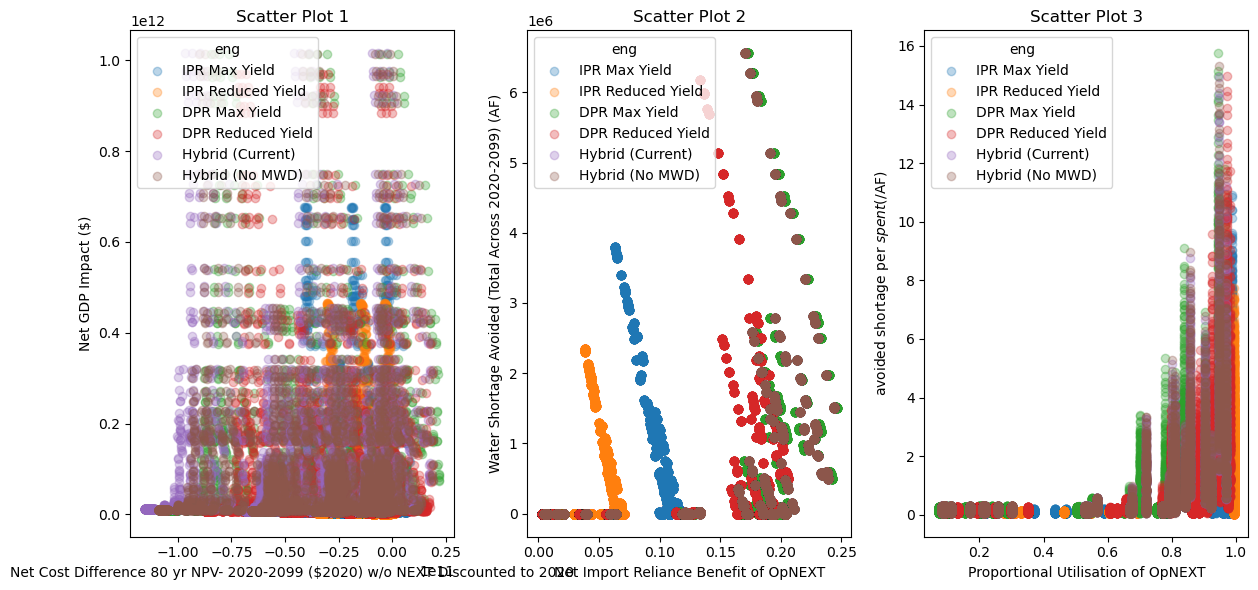

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
data = pd.read_csv('OpNEXToutputs_Mar2024_A.csv')

#Calculate new variable column Shortage Avoided per Cost
data['GDP Benefit per LA Cost'] = data['Net GDP Impact ($)'] / data['80 yr NPV- 2020-2099 ($2020) w  NEXT Discounted to 2020'] 

# Define the variables for the scatter plots
x_variables = ['Net Cost Difference 80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020', 'Net Import Reliance Benefit of OpNEXT','Proportional Utilisation of OpNEXT']
y_variables = ['Net GDP Impact ($)', 'Water Shortage Avoided (Total Across 2020-2099) (AF)','avoided shortage per $ spent($/AF)']
color_variable = 'eng'  # This variable will determine the colors of the points

# Define the unique values in the color variable
color_values = data[color_variable].unique()

# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Create scatter plots for each subplot
for i in range(3):
    # Filter the data for the current subplot
    x_var = x_variables[i]
    y_var = y_variables[i]
    ax = axes[i]
    
    # Plot the scatter plot for the current subplot
    for color_value in color_values:
        # Filter the data for the current color value
        subset = data[data[color_variable] == color_value]
        
        # Plot the scatter plot for the current color value
        ax.scatter(subset[x_var], subset[y_var], label=color_value, alpha=0.3)
    
    # Add labels and legend to the subplot
    ax.set_xlabel(f'{x_var}')
    ax.set_ylabel(f'{y_var}')
    ax.set_title(f'Scatter Plot {i+1}')
    ax.legend(title=color_variable)

# Adjust layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()



+----------+----------------+---------------+---------------+----------------+
| Variable |    X Lower     |    X Upper    |    Y Lower    |    Y Upper     |
+----------+----------------+---------------+---------------+----------------+
|   haz    | -6925631102.0  | -3149937870.0 | 8769042815.0  | 279000000000.0 |
|   exo    | -7698412474.0  | 2938210271.0  | 54574733102.0 | 225000000000.0 |
|   endo   | -26200066819.0 | 5772103507.0  | 1732478682.0  | 112000000000.0 |
| overrun  | -55356780274.0 | -3562358797.0 | 56091671771.0 | 56091671771.0  |
+----------+----------------+---------------+---------------+----------------+
+----------+-------------+-------------+-------------+-------------+
| Variable |   X Lower   |   X Upper   |   Y Lower   |   Y Upper   |
+----------+-------------+-------------+-------------+-------------+
|   haz    | 0.191732241 | 0.243589413 |     0.0     | 4518444.701 |
|   exo    | 0.213030694 | 0.23384784  | 553741.029  | 2183694.751 |
|   endo   | 0.02977240

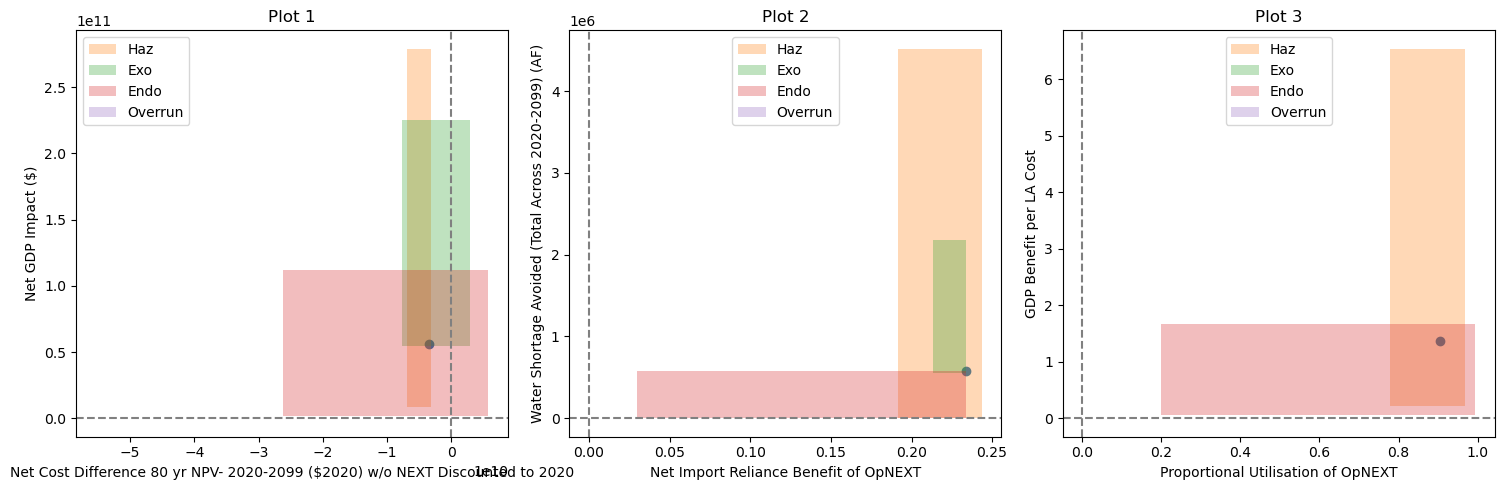

In [154]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Reading in dataset for automated graph generation
df = pd.read_csv('OpNEXToutputs_Mar2024_A.csv')

#Calculate new variable column Shortage Avoided per Cost
df['GDP Benefit per LA Cost'] = df['Net GDP Impact ($)'] / df['80 yr NPV- 2020-2099 ($2020) w  NEXT Discounted to 2020'] 

# Establishing Baseline Variables
#Hazards
climate_base = 'miroc6_r1i1p1f1_ssp370'
EQ_base = 0

#Scenarios
compact_base = 'Existing Policy'
costr_base=0.0319
thresh_base=373623
pwsc_base='IPR+DPR'
prop_base=0.17512

#Strategies
eng_base = 'Hybrid (Current)'
disc_base= 0.025
spreadr_base=0
pumpr_base=0
cons_base= 1
addcons_base= 0
overrun_base= 1

# Filter for Baseline Value
condition_climate0 = df['climate'] == climate_base 
condition_EQ0 = df['EQ'] == EQ_base

condition_compact0 = df['compact'] == compact_base
condition_mwdcostr0 = df['mwdcostr'] == costr_base
condition_mwdthresh0 = df['mwdthresh'] == thresh_base
condition_pwsc0 = df['pwsc'] == pwsc_base
condition_mwdprop0 = df['mwdprop'] == prop_base

condition_eng0 = df['eng'] == eng_base
condition_disc0 = df['disc'] == disc_base
condition_spreadr0 = df['spreadr'] == spreadr_base
condition_pumpr0 = df['pumpr'] == pumpr_base
condition_cons0 = df['cons'] == cons_base
condition_addcons0 = df['addcons'] == addcons_base

condition_overrun0 = df['overrun'] == overrun_base

combined_condition_base = (
    condition_climate0 & condition_EQ0 & condition_compact0 & condition_mwdcostr0 &
    condition_mwdthresh0 & condition_pwsc0 & condition_mwdprop0 & condition_eng0 &
    condition_disc0 & condition_spreadr0 & condition_pumpr0 & condition_cons0 &
    condition_addcons0 & condition_overrun0
)

# Hazards Conditional Filter
condition_climate1 = df['climate'].notnull()
condition_EQ1 = df['EQ'].notnull()

condition_compact1 = df['compact'] == compact_base
condition_mwdcostr1 = df['mwdcostr'] == costr_base
condition_mwdthresh1 = df['mwdthresh'] == thresh_base
condition_pwsc1 = df['pwsc'] == pwsc_base
condition_mwdprop1 = df['mwdprop'] == prop_base

condition_eng1 = df['eng'] == eng_base
condition_disc1 = df['disc'] == disc_base
condition_spreadr1 = df['spreadr'] == spreadr_base
condition_pumpr1 = df['pumpr'] == pumpr_base
condition_cons1 = df['cons'] == cons_base
condition_addcons1 = df['addcons'] == addcons_base

condition_overrun1 = df['overrun'] == overrun_base

combined_condition_haz = (
    condition_climate1 & condition_EQ1 & condition_compact1 & condition_mwdcostr1 &
    condition_mwdthresh1 & condition_pwsc1 & condition_mwdprop1 & condition_eng1 &
    condition_disc1 & condition_spreadr1 & condition_pumpr1 & condition_cons1 &
    condition_addcons1 & condition_overrun1
)

# Exogenous Factors Conditional Filter
condition_climate2 = df['climate'] == climate_base
condition_EQ2 = df['EQ'] == EQ_base

condition_compact2 = df['compact'].notnull()
condition_mwdcostr2 = df['mwdcostr'].notnull()
condition_mwdthresh2 = df['mwdthresh'].notnull()
condition_pwsc2 = df['pwsc'].notnull()
condition_mwdprop2 = df['mwdprop'].notnull()

condition_eng2 = df['eng'] == eng_base
condition_disc2 = df['disc'] == disc_base
condition_spreadr2 = df['spreadr'] == spreadr_base
condition_pumpr2 = df['pumpr'] == pumpr_base
condition_cons2 = df['cons'] == cons_base
condition_addcons2 = df['addcons'] == addcons_base

condition_overrun2 = df['overrun'] == overrun_base

combined_condition_exo = (
    condition_climate2 & condition_EQ2 & condition_compact2 & condition_mwdcostr2 &
    condition_mwdthresh2 & condition_pwsc2 & condition_mwdprop2 & condition_eng2 &
    condition_disc2 & condition_spreadr2 & condition_pumpr2 & condition_cons2 &
    condition_addcons2 & condition_overrun2
)

# Endogenous Factors Conditional Filter
condition_climate3 = df['climate'] == climate_base
condition_EQ3 = df['EQ'] == EQ_base

condition_compact3 = df['compact'] == compact_base
condition_mwdcostr3 = df['mwdcostr'] == costr_base
condition_mwdthresh3 = df['mwdthresh'] == thresh_base
condition_pwsc3 = df['pwsc'] == pwsc_base
condition_mwdprop3 = df['mwdprop'] == prop_base

condition_eng3 = df['eng'].notnull()
condition_disc3 = df['disc'].notnull()
condition_spreadr3 = df['spreadr'].notnull()
condition_pumpr3 = df['pumpr'].notnull()
condition_cons3 = df['cons'].notnull()
condition_addcons3 = df['addcons'].notnull()

condition_overrun3 = df['overrun'] == 1

combined_condition_endo = (
    condition_climate3 & condition_EQ3 & condition_compact3 & condition_mwdcostr3 &
    condition_mwdthresh3 & condition_pwsc3 & condition_mwdprop3 & condition_eng3 &
    condition_disc3 & condition_spreadr3 & condition_pumpr3 & condition_cons3 &
    condition_addcons3 & condition_overrun3
)

# Overrun Factors Conditional Filter
condition_climate4 = df['climate'] == climate_base
condition_EQ4 = df['EQ'] == EQ_base

condition_compact4 = df['compact'] == compact_base
condition_mwdcostr4 = df['mwdcostr'] == costr_base
condition_mwdthresh4 = df['mwdthresh'] == thresh_base
condition_pwsc4 = df['pwsc'] == pwsc_base
condition_mwdprop4 = df['mwdprop'] == prop_base

condition_eng4 = df['eng'] == eng_base
condition_disc4 = df['disc'] == disc_base
condition_spreadr4 = df['spreadr'] == spreadr_base
condition_pumpr4 = df['pumpr'] == pumpr_base
condition_cons4 = df['cons'] == cons_base
condition_addcons4 = df['addcons'] == addcons_base

condition_overrun4 = df['overrun'].notnull()

combined_condition_over = (
    condition_climate4 & condition_EQ4 & condition_compact4 & condition_mwdcostr4 &
    condition_mwdthresh4 & condition_pwsc4 & condition_mwdprop4 & condition_eng4 &
    condition_disc4 & condition_spreadr4 & condition_pumpr4 & condition_cons4 &
    condition_addcons4 & condition_overrun4
)

# Apply the combined filter condition to the DataFrame
filtered_df_base = df[combined_condition_base]
filtered_df_haz = df[combined_condition_haz]
filtered_df_exo = df[combined_condition_exo]
filtered_df_endo = df[combined_condition_endo]
filtered_df_over = df[combined_condition_over]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Add horizontal and vertical lines at 0
for ax in axes:
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')

# Define a list to store highlighted area coordinates
highlighted_areas = []

# Define x and y variables for plots
x_variables = ['Net Cost Difference 80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020', 'Net Import Reliance Benefit of OpNEXT','Proportional Utilisation of OpNEXT']
y_variables = ['Net GDP Impact ($)', 'Water Shortage Avoided (Total Across 2020-2099) (AF)','GDP Benefit per LA Cost']

for i in range(3):
    # Filter the data for the current subplot
    x_var = x_variables[i]
    y_var = y_variables[i]
    
    # Baseline Values
    x_base = filtered_df_base[x_var].mean()
    y_base = filtered_df_base[y_var].mean()

    # Haz Range Values
    x_haz_lower = filtered_df_haz[x_var].min()
    x_haz_upper = filtered_df_haz[x_var].max()
    y_haz_lower = filtered_df_haz[y_var].min()
    y_haz_upper = filtered_df_haz[y_var].max()

    # Exo Range Values
    x_exo_lower = filtered_df_exo[x_var].min()
    x_exo_upper = filtered_df_exo[x_var].max()
    y_exo_lower = filtered_df_exo[y_var].min()
    y_exo_upper = filtered_df_exo[y_var].max()

    # Endo Range Values
    x_endo_lower = filtered_df_endo[x_var].min()
    x_endo_upper = filtered_df_endo[x_var].max()
    y_endo_lower = filtered_df_endo[y_var].min()
    y_endo_upper = filtered_df_endo[y_var].max()

    # Overrun Range Values
    x_over_lower = filtered_df_over[x_var].min()
    x_over_upper = filtered_df_over[x_var].max()
    y_over_lower = filtered_df_over[y_var].min()
    y_over_upper = filtered_df_over[y_var].max()

    # Highlighted area coordinates
    highlighted_area = {
        'haz': {'x': [x_haz_lower, x_haz_upper, x_haz_upper, x_haz_lower], 'y': [y_haz_lower, y_haz_lower, y_haz_upper, y_haz_upper]},
        'exo': {'x': [x_exo_lower, x_exo_upper, x_exo_upper, x_exo_lower], 'y': [y_exo_lower, y_exo_lower, y_exo_upper, y_exo_upper]},
        'endo': {'x': [x_endo_lower, x_endo_upper, x_endo_upper, x_endo_lower], 'y': [y_endo_lower, y_endo_lower, y_endo_upper, y_endo_upper]},
        'overrun': {'x': [x_over_lower, x_over_upper, x_over_upper, x_over_lower], 'y': [y_over_lower, y_over_lower, y_over_upper, y_over_upper]}
}
    
    # Append the highlighted area coordinates to the list
    highlighted_areas.append(highlighted_area)
    
    # Storing Highlited Area Limits in output table for later printing
    highlighted_data= [
        ['haz', x_haz_lower, x_haz_upper,y_haz_lower, y_haz_upper],
        ['exo', x_exo_lower, x_exo_upper, y_exo_lower, y_exo_upper],
        ['endo', x_endo_lower, x_endo_upper, y_endo_lower, y_endo_upper],
        ['overrun', x_over_lower, x_over_upper, y_over_lower, y_over_upper]
    ]

    highlighted_headers=['Variable', 'X Lower', 'X Upper', 'Y Lower', 'Y Upper']

    table=tabulate(highlighted_data, headers=highlighted_headers, tablefmt="pretty")
    
    print(table)

    # Scatter plot
    axes[i].scatter(x_base, y_base)

    # Fill the highlighted areas
    for category, coordinates in highlighted_area.items():
        axes[i].fill(coordinates['x'], coordinates['y'], alpha=0.3, label=category.capitalize())

    # Set labels and title
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel(y_var)
    axes[i].set_title('Plot ' + str(i+1))
    axes[i].legend()

plt.tight_layout() 
plt.show()

In [139]:
Axes.twinx()

USE TWIN X. CALL DR. YUE. 


SyntaxError: invalid syntax (849690099.py, line 1)

In [170]:
#Creating specific variable range analysis

import matplotlib.pyplot as plt
from tabulate import tabulate

# Reading in dataset for automated graph generation
df = pd.read_csv('OpNEXToutputs_Mar2024_A.csv')

#Calculate new variable column Shortage Avoided per Cost
df['GDP Benefit per LA Cost'] = df['Net GDP Impact ($)'] / df['80 yr NPV- 2020-2099 ($2020) w  NEXT Discounted to 2020'] 

# Establishing Baseline Variables
#Hazards
climate_base = 'miroc6_r1i1p1f1_ssp370'
EQ_base = 0

#Scenarios
compact_base = 'Existing Policy'
costr_base=0.0319
thresh_base=373623
pwsc_base='IPR+DPR'
prop_base=0.17512

#Strategies
eng_base = 'Hybrid (Current)'
disc_base= 0.025
spreadr_base=0
pumpr_base=0
cons_base= 1
addcons_base= 0
overrun_base= 1

# Filter for variable climate results holding all else constant
condition_climate0 = df['climate'].notnull()
condition_EQ0 = df['EQ'] == EQ_base

condition_compact0 = df['compact'] == compact_base
condition_mwdcostr0 = df['mwdcostr'] == costr_base
condition_mwdthresh0 = df['mwdthresh'] == thresh_base
condition_pwsc0 = df['pwsc'] == pwsc_base
condition_mwdprop0 = df['mwdprop'] == prop_base

condition_eng0 = df['eng'] == eng_base
condition_disc0 = df['disc'] == disc_base
condition_spreadr0 = df['spreadr'] == spreadr_base
condition_pumpr0 = df['pumpr'] == pumpr_base
condition_cons0 = df['cons'] == cons_base
condition_addcons0 = df['addcons'] == addcons_base

condition_overrun0 = df['overrun'] == overrun_base

combined_condition_climate = (
    condition_climate0 & condition_EQ0 & condition_compact0 & condition_mwdcostr0 &
    condition_mwdthresh0 & condition_pwsc0 & condition_mwdprop0 & condition_eng0 &
    condition_disc0 & condition_spreadr0 & condition_pumpr0 & condition_cons0 &
    condition_addcons0 & condition_overrun0
)

# Apply the combined filter condition to the DataFrame
filtered_df_climate = df[combined_condition_climate]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 8, figsize=(20, 3))

'''

# Hazards Conditional Filter
condition_climate1 = df['climate'].notnull()
condition_EQ1 = df['EQ'].notnull()

condition_compact1 = df['compact'] == compact_base
condition_mwdcostr1 = df['mwdcostr'] == costr_base
condition_mwdthresh1 = df['mwdthresh'] == thresh_base
condition_pwsc1 = df['pwsc'] == pwsc_base
condition_mwdprop1 = df['mwdprop'] == prop_base

condition_eng1 = df['eng'] == eng_base
condition_disc1 = df['disc'] == disc_base
condition_spreadr1 = df['spreadr'] == spreadr_base
condition_pumpr1 = df['pumpr'] == pumpr_base
condition_cons1 = df['cons'] == cons_base
condition_addcons1 = df['addcons'] == addcons_base

condition_overrun1 = df['overrun'] == overrun_base

combined_condition_haz = (
    condition_climate1 & condition_EQ1 & condition_compact1 & condition_mwdcostr1 &
    condition_mwdthresh1 & condition_pwsc1 & condition_mwdprop1 & condition_eng1 &
    condition_disc1 & condition_spreadr1 & condition_pumpr1 & condition_cons1 &
    condition_addcons1 & condition_overrun1
)

# Exogenous Factors Conditional Filter
condition_climate2 = df['climate'] == climate_base
condition_EQ2 = df['EQ'] == EQ_base

condition_compact2 = df['compact'].notnull()
condition_mwdcostr2 = df['mwdcostr'].notnull()
condition_mwdthresh2 = df['mwdthresh'].notnull()
condition_pwsc2 = df['pwsc'].notnull()
condition_mwdprop2 = df['mwdprop'].notnull()

condition_eng2 = df['eng'] == eng_base
condition_disc2 = df['disc'] == disc_base
condition_spreadr2 = df['spreadr'] == spreadr_base
condition_pumpr2 = df['pumpr'] == pumpr_base
condition_cons2 = df['cons'] == cons_base
condition_addcons2 = df['addcons'] == addcons_base

condition_overrun2 = df['overrun'] == overrun_base

combined_condition_exo = (
    condition_climate2 & condition_EQ2 & condition_compact2 & condition_mwdcostr2 &
    condition_mwdthresh2 & condition_pwsc2 & condition_mwdprop2 & condition_eng2 &
    condition_disc2 & condition_spreadr2 & condition_pumpr2 & condition_cons2 &
    condition_addcons2 & condition_overrun2
)

# Endogenous Factors Conditional Filter
condition_climate3 = df['climate'] == climate_base
condition_EQ3 = df['EQ'] == EQ_base

condition_compact3 = df['compact'] == compact_base
condition_mwdcostr3 = df['mwdcostr'] == costr_base
condition_mwdthresh3 = df['mwdthresh'] == thresh_base
condition_pwsc3 = df['pwsc'] == pwsc_base
condition_mwdprop3 = df['mwdprop'] == prop_base

condition_eng3 = df['eng'].notnull()
condition_disc3 = df['disc'].notnull()
condition_spreadr3 = df['spreadr'].notnull()
condition_pumpr3 = df['pumpr'].notnull()
condition_cons3 = df['cons'].notnull()
condition_addcons3 = df['addcons'].notnull()

condition_overrun3 = df['overrun'] == 1

combined_condition_endo = (
    condition_climate3 & condition_EQ3 & condition_compact3 & condition_mwdcostr3 &
    condition_mwdthresh3 & condition_pwsc3 & condition_mwdprop3 & condition_eng3 &
    condition_disc3 & condition_spreadr3 & condition_pumpr3 & condition_cons3 &
    condition_addcons3 & condition_overrun3
)

# Overrun Factors Conditional Filter
condition_climate4 = df['climate'] == climate_base
condition_EQ4 = df['EQ'] == EQ_base

condition_compact4 = df['compact'] == compact_base
condition_mwdcostr4 = df['mwdcostr'] == costr_base
condition_mwdthresh4 = df['mwdthresh'] == thresh_base
condition_pwsc4 = df['pwsc'] == pwsc_base
condition_mwdprop4 = df['mwdprop'] == prop_base

condition_eng4 = df['eng'] == eng_base
condition_disc4 = df['disc'] == disc_base
condition_spreadr4 = df['spreadr'] == spreadr_base
condition_pumpr4 = df['pumpr'] == pumpr_base
condition_cons4 = df['cons'] == cons_base
condition_addcons4 = df['addcons'] == addcons_base

condition_overrun4 = df['overrun'].notnull()

combined_condition_over = (
    condition_climate4 & condition_EQ4 & condition_compact4 & condition_mwdcostr4 &
    condition_mwdthresh4 & condition_pwsc4 & condition_mwdprop4 & condition_eng4 &
    condition_disc4 & condition_spreadr4 & condition_pumpr4 & condition_cons4 &
    condition_addcons4 & condition_overrun4
)

# Apply the combined filter condition to the DataFrame
filtered_df_base = df[combined_condition_base]
filtered_df_haz = df[combined_condition_haz]
filtered_df_exo = df[combined_condition_exo]
filtered_df_endo = df[combined_condition_endo]
filtered_df_over = df[combined_condition_over]

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 8, figsize=(20, 3))


clim_max_variation= 

df['climate']
clim_range_max
clim_range_mean
x_range_max= 
print (x_base)
print (y_base)

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 8, figsize=(20, 3))

# Add horizontal and vertical lines at 0
for ax in axes:
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')



# Establishing Baseline Variables
#Hazards
climate_base = 'miroc6_r1i1p1f1_ssp370'

#Scenarios
compact_base = 'Existing Policy'
costr_base=0.0319
pwsc_base='IPR+DPR'

#Strategies
eng_base = 'Hybrid (Current)'
disc_base= 0.025
cons_base= 1
overrun_base= 1
'''

"\n\n# Hazards Conditional Filter\ncondition_climate1 = df['climate'].notnull()\ncondition_EQ1 = df['EQ'].notnull()\n\ncondition_compact1 = df['compact'] == compact_base\ncondition_mwdcostr1 = df['mwdcostr'] == costr_base\ncondition_mwdthresh1 = df['mwdthresh'] == thresh_base\ncondition_pwsc1 = df['pwsc'] == pwsc_base\ncondition_mwdprop1 = df['mwdprop'] == prop_base\n\ncondition_eng1 = df['eng'] == eng_base\ncondition_disc1 = df['disc'] == disc_base\ncondition_spreadr1 = df['spreadr'] == spreadr_base\ncondition_pumpr1 = df['pumpr'] == pumpr_base\ncondition_cons1 = df['cons'] == cons_base\ncondition_addcons1 = df['addcons'] == addcons_base\n\ncondition_overrun1 = df['overrun'] == overrun_base\n\ncombined_condition_haz = (\n    condition_climate1 & condition_EQ1 & condition_compact1 & condition_mwdcostr1 &\n    condition_mwdthresh1 & condition_pwsc1 & condition_mwdprop1 & condition_eng1 &\n    condition_disc1 & condition_spreadr1 & condition_pumpr1 & condition_cons1 &\n    condition_addc

AttributeError: 'str' object has no attribute 'iloc'

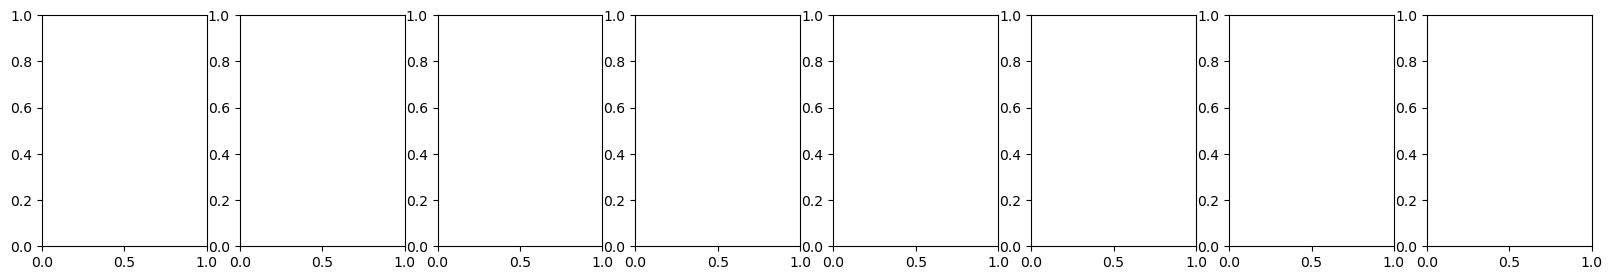

In [218]:
#Creating specific variable range analysis

import matplotlib.pyplot as plt
from tabulate import tabulate

# Reading in dataset for automated graph generation
df = pd.read_csv('OpNEXToutputs_Mar2024_A.csv')

#Calculate new variable column Shortage Avoided per Cost
df['GDP Benefit per LA Cost'] = df['Net GDP Impact ($)'] / df['80 yr NPV- 2020-2099 ($2020) w  NEXT Discounted to 2020'] 

# Establishing Baseline Variables
#Hazards
climate_base = 'miroc6_r1i1p1f1_ssp370'
EQ_base = 0

#Scenarios
compact_base = 'Existing Policy'
costr_base=0.0319
thresh_base=373623
pwsc_base='IPR+DPR'
prop_base=0.17512

#Strategies
eng_base = 'Hybrid (Current)'
disc_base= 0.025
spreadr_base=0
pumpr_base=0
cons_base= 1
addcons_base= 0
overrun_base= 1

# Filter for variable climate results holding all else constant
condition_climate0 = df['climate'].notnull()
condition_EQ0 = df['EQ'] == EQ_base

condition_compact0 = df['compact'] == compact_base
condition_mwdcostr0 = df['mwdcostr'] == costr_base
condition_mwdthresh0 = df['mwdthresh'] == thresh_base
condition_pwsc0 = df['pwsc'] == pwsc_base
condition_mwdprop0 = df['mwdprop'] == prop_base

condition_eng0 = df['eng'] == eng_base
condition_disc0 = df['disc'] == disc_base
condition_spreadr0 = df['spreadr'] == spreadr_base
condition_pumpr0 = df['pumpr'] == pumpr_base
condition_cons0 = df['cons'] == cons_base
condition_addcons0 = df['addcons'] == addcons_base

condition_overrun0 = df['overrun'] == overrun_base

combined_condition_climate = (
    condition_climate0 & condition_EQ0 & condition_compact0 & condition_mwdcostr0 &
    condition_mwdthresh0 & condition_pwsc0 & condition_mwdprop0 & condition_eng0 &
    condition_disc0 & condition_spreadr0 & condition_pumpr0 & condition_cons0 &
    condition_addcons0 & condition_overrun0
)

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 8, figsize=(20, 3))

# Apply the combined filter condition to the DataFrame
pd.set_option('display.max_columns', None)
filtered_df_climate = df[combined_condition_climate]
filtered_df_climate.head()
df_climates=filtered_df_climate[['climate','Net Cost Difference 80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020', 'Net Import Reliance Benefit of OpNEXT','Proportional Utilisation of OpNEXT','Net GDP Impact ($)', 'Water Shortage Avoided (Total Across 2020-2099) (AF)','GDP Benefit per LA Cost']]
df_climates

# Select the key_variable row
key_variable_row = df_climates[df_climates['climate'] == climate_base.iloc[0]]


In [202]:
import pandas as pd

# Set the display options
pd.set_option('display.max_columns', None)

# Print the first row of the DataFrame
filtered_df_over.head()


,index,climate,EQ,compact,mwdcostr,mwdthresh,pwsc,mwdprop,eng,disc,spreadr,pumpr,cons,addcons,overrun,uniquehash,80 yr NPV- 2020-2099 ($2020) w NEXT Discounted to 2020,80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020,Net Cost Difference 80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020,"Benefit per Acre-foot\n ($/AF)(2020$, Discounted)",Volume of Operation NEXT Water Available\n(AF),Proportional Utilisation of OpNEXT,Water Shortage Avoided (Total Across 2020-2099) (AF),Net Jobs Change (FTEs across 2020-2085),Net GDP Impact ($),Import Reliance,Import Reliance,Net Import Reliance Benefit of OpNEXT,Reservoir level prior to EQ with OpNEXT (AF),Reservoir level prior to EQ w/o OpNEXT (AF),Proportional reservoir level w/ OpNEXT (%),Proportional reservoir level w/o OpNEXT (%),Unmet Water Supply Needs in EQ Y1 w OpNEXT (AF),Unmet Water Supply Needs in EQ Y1 w/o OpNEXT(AF),GDP Benefit per LA Cost
29601,29601,miroc6_r1i1p1f1_ssp370,0,Existing Policy,0.0319,373623,IPR+DPR,0.17512,Hybrid (Current),0.025,0,0,1,0,1.0,3.530000e+18,4.094118e+10,37378824358,-3.562359e+09,-294.498035,12096375.46,0.905182,573598.4946,1453905.333,5.609167e+10,0.182315,0.415839,0.233524,NaN,NaN,NaN,NaN,NaN,NaN,1.370055
29602,29602,miroc6_r1i1p1f1_ssp370,0,Existing Policy,0.0319,373623,IPR+DPR,0.17512,Hybrid (Current),0.025,0,0,1,0,1.5,-6.060000e+18,6.252219e+10,37378824358,-2.514337e+10,-2078.586915,12096375.46,0.905182,573598.4946,1453905.333,5.609167e+10,0.182315,0.415839,0.233524,NaN,NaN,NaN,NaN,NaN,NaN,0.897148
29603,29603,miroc6_r1i1p1f1_ssp370,0,Existing Policy,0.0319,373623,IPR+DPR,0.17512,Hybrid (Current),0.025,0,0,1,0,2.0,-7.250000e+18,9.273560e+10,37378824358,-5.535678e+10,-4576.311348,12096375.46,0.905182,573598.4946,1453905.333,5.609167e+10,0.182315,0.415839,0.233524,NaN,NaN,NaN,NaN,NaN,NaN,0.604856


In [207]:
df_climates

,climate,Net Cost Difference 80 yr NPV- 2020-2099 ($2020) w/o NEXT Discounted to 2020,Net Import Reliance Benefit of OpNEXT,Proportional Utilisation of OpNEXT,Net GDP Impact ($),Water Shortage Avoided (Total Across 2020-2099) (AF),GDP Benefit per LA Cost
441,access-cm2_r5i1p1f1_ssp370,-5.694163e+09,0.202787,0.809447,9.588996e+09,2.333088e+03,0.233276
5301,canesm5_r1i1p2f1_ssp370,-4.328842e+09,0.199481,0.946519,2.790000e+11,4.518445e+06,6.538137
10161,cesm2_r11i1p1f1_ssp370,-6.633040e+09,0.191732,0.793150,1.835771e+10,1.476078e+05,0.442556
15021,cnrm-esm2-1_r1i1p1f2_ssp370,-6.134015e+09,0.201699,0.840279,5.200918e+10,1.103156e+06,1.222933
19881,ec-earth3_r1i1p1f1_ssp370,-3.149938e+09,0.243589,0.968569,9.741308e+10,1.511736e+06,2.392753
24741,ec-earth3-veg_r1i1p1f1_ssp370,-6.692200e+09,0.193427,0.810755,5.958627e+10,1.319041e+06,1.392586
29601,miroc6_r1i1p1f1_ssp370,-3.562359e+09,0.233524,0.905182,5.609167e+10,5.735985e+05,1.370055
34461,mpi-esm1-2-hr_r7i1p1f1_ssp370,-3.524462e+09,0.238184,0.921838,3.572478e+10,5.687733e+05,0.863110
39321,noresm2-mm_r1i1p1f1_ssp370,-6.543827e+09,0.195560,0.790500,8.769043e+09,0.000000e+00,0.210520
44181,taiesm1_r1i1p1f1_ssp370,-6.925631e+09,0.192112,0.777668,8.769043e+09,0.000000e+00,0.211570


In [69]:
print(climate_base)
print (df['climate'].unique())
print(condition_climate0.unique())

print(EQ_base)
print(df['EQ'].unique())
print(condition_EQ0.unique())

print(compact_base)
print(df['compact'].unique())
print(condition_compact0.unique())

print(costr_base)
print(df['mwdcostr'].unique())
print(condition_mwdcostr0.unique())

print(thresh_base)
print(df['mwdthresh'].unique())
print(condition_mwdthresh0.unique())

print(pwsc_base)
print(df['pwsc'].unique())
print(condition_pwsc0.unique())

print(prop_base)
print(df['mwdprop'].unique())
print(condition_mwdprop0.unique())

print(eng_base)
print(df['eng'].unique())
print(condition_eng0.unique())

print(disc_base)
print(df['disc'].unique())
print(condition_disc0.unique())

print(spreadr_base)
print(df['spreadr'].unique())
print(condition_spreadr0.unique())

print(pumpr_base)
print(df['pumpr'].unique())
print(condition_pumpr0.unique())

print(cons_base)
print(df['cons'].unique())
print(condition_cons0.unique())

print(addcons_base)
print(df['addcons'].unique())
print(condition_addcons0.unique())

print(overrun_base)
print(df['overrun'].unique())
print(condition_overrun0.unique())


miroc6_r1i1p1f1_ssp370
['access-cm2_r5i1p1f1_ssp370' 'canesm5_r1i1p2f1_ssp370'
 'cesm2_r11i1p1f1_ssp370' 'cnrm-esm2-1_r1i1p1f2_ssp370'
 'ec-earth3_r1i1p1f1_ssp370' 'ec-earth3-veg_r1i1p1f1_ssp370'
 'miroc6_r1i1p1f1_ssp370' 'mpi-esm1-2-hr_r7i1p1f1_ssp370'
 'noresm2-mm_r1i1p1f1_ssp370' 'taiesm1_r1i1p1f1_ssp370']
[False  True]
0
[0]
[ True]
Existing Policy
['Existing Policy' 'AA1-2024' 'AA1-2025' 'AA2-2024' 'AA2-2025']
[ True False]
0.0319
[0.0245 0.0319 0.0391]
[False]
373623
[373623]
[False]
IPR+DPR
['IPR+DPR' 'None']
[ True False]
0.17512
[0.17512]
[False]
Hybrid (Current)
['IPR Max Yield' 'IPR Reduced Yield' 'DPR Max Yield' 'DPR Reduced Yield'
 'Hybrid (Current)' 'Hybrid (No MWD)']
[False  True]
0.025
[0.01  0.025 0.055]
[False]
0
[0]
[False]
0
[0]
[False]
1
[1 2 3]
[False]
0
[0]
[False]
1
[1.  1.5 2. ]
[False]


In [57]:
print (df['climate'].unique())

['access-cm2_r5i1p1f1_ssp370' 'canesm5_r1i1p2f1_ssp370'
 'cesm2_r11i1p1f1_ssp370' 'cnrm-esm2-1_r1i1p1f2_ssp370'
 'ec-earth3_r1i1p1f1_ssp370' 'ec-earth3-veg_r1i1p1f1_ssp370'
 'miroc6_r1i1p1f1_ssp370' 'mpi-esm1-2-hr_r7i1p1f1_ssp370'
 'noresm2-mm_r1i1p1f1_ssp370' 'taiesm1_r1i1p1f1_ssp370']


In [50]:
df

,Unnamed: 0,index,climate,EQ,compact,mwdcostr,mwdthresh,pwsc,mwdprop,engineering,disc,spreading_inc_rate,gw_pumping_inc_rate,cons,addcons,overrun,uniquehash
0,0,0,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.010,0,0,1,0,1.0,4087083449974699973
1,1,1,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.010,0,0,1,0,1.5,6317647429036748561
2,2,2,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.010,0,0,1,0,2.0,-1241078240498359664
3,3,3,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.010,0,0,2,0,1.0,-3791880292214998183
4,4,4,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.010,0,0,2,0,1.5,8998364033058049715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48595,48595,48595,taiesm1_r1i1p1f1_ssp370,0,AA2-2025,0.0391,373623,None,0.17512,Hybrid (No MWD),0.055,0,0,2,0,1.5,-3299551130118319088
48596,48596,48596,taiesm1_r1i1p1f1_ssp370,0,AA2-2025,0.0391,373623,None,0.17512,Hybrid (No MWD),0.055,0,0,2,0,2.0,-4195122732863880667
48597,48597,48597,taiesm1_r1i1p1f1_ssp370,0,AA2-2025,0.0391,373623,None,0.17512,Hybrid (No MWD),0.055,0,0,3,0,1.0,-663290639386151511
48598,48598,48598,taiesm1_r1i1p1f1_ssp370,0,AA2-2025,0.0391,373623,None,0.17512,Hybrid (No MWD),0.055,0,0,3,0,1.5,693332057028032288


In [ ]:
# Read scenario inputs into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024.csv'
output_df = pd.read_csv(output_csv_path)

n_processed = len(output_df)

inputs_df = df.iloc[n_processed:, :]

In [109]:
small = df.iloc[:5]

In [112]:
mask = small["overrun"] == 2.0

In [116]:
small[~mask]

,index,climate,EQ,compact,mwdcostr,mwdthresh,pwsc,mwdprop,engineering,disc,spreading_inc_rate,gw_pumping_inc_rate,cons,addcons,overrun,unique_hash
0,0,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.01,0,0,1,0,1.0,5580934164576002689
1,1,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.01,0,0,1,0,1.5,-8526692971204390424
3,3,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.01,0,0,2,0,1.0,-3040959135437491082
4,4,access-cm2_r5i1p1f1_ssp370,0,Existing Policy,0.0245,373623,IPR+DPR,0.17512,IPR Max Yield,0.01,0,0,2,0,1.5,7933974182321106396


In [106]:
def hash_pandas_row(row) -> int:
    return hash(tuple(row))

# Read scenario inputs into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')
df["unique_hash"] = df.apply(hash_pandas_row, axis=1)

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024.csv'

# assuming that this dataframe has the unique_hash column
output_df = pd.read_csv(output_csv_path)

processed_row_mask = output_df["unique_hash"].isin(df["unique_hash"])
inputs_still_to_process = df[~processed_row_mask]

In [84]:
# Read scenario inputs into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')
df["unique_hash"] = df.apply(lambda row: hash(tuple(row)), axis=1)

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024.csv'
output_df = pd.read_csv(output_csv_path)

In [83]:
import os
import pandas as pd
import csv
from datetime import datetime
from tqdm import tqdm

# Read scenario inputs into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024.csv'

#Locating file and noting which sheet to change
home_path = '/Users/profcalculus/Desktop/Ox/LCI/LADWP/OpNEXT Report Writing/Model Components/AC Model'
excel = os.path.join(home_path, '24.03.04-Operation NEXT AC Model_python.xlsx')

# Load Excel workbook
wb = xw.Book(excel)
sheet_ana = wb.sheets['Analysis Home']
sheet_wNEXT = wb.sheets['AC-Master w NEXT']
sheet_woNEXT = wb.sheets['AC-Master wo NEXT']

#Defining the output outcome headers, outcome values, and key variable headers
outputs=[]
output_values = "I5:Z5"
value_headers=sheet_ana["I3:Z3"].value
outputs_headers = [['climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun'] + value_headers]
outputs=[outputs_headers]

# Initialize variables for file writing logic
processed_rows = set()

#Locating cells for key variables and each cell's possible variable values to evaluate. Key variables conceptually split between hazards, strategies, and scenarios
#Hazards (Key hazard model variables that beyond any institutions' control)
climate_cell = "C9"
EQ_timing_cell = "C11"
#Scenarios (Key model policy variables that are exogenous to LADWP)
cra_compact_cell="C10"
mwd_costr_cell='C25'
mwd_threshold_cell='C39'
pwsc_cell='C20'
mwd_prop_ladwp_cell='C58'
#Strategies (Key model variables that are endogenous to LADWP)
engineering_cell = "C18"
disc_cell='C24'
spreading_inc_rate_cell='C45'
gw_pumping_inc_rate_cell='C47'
cons_cell='C50'
addcons_cell='C28'
overrun_cell='C19'

# Setting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = 'miroc6_r1i1p1f1_ssp370'
sheet_ana[EQ_timing_cell].value = '0'

#Scenarios
sheet_ana[cra_compact_cell].value = 'Existing Policy'
sheet_ana[mwd_costr_cell].value='0.0319'
sheet_ana[mwd_threshold_cell].value='373623'
sheet_ana[pwsc_cell].value='IPR+DPR'
sheet_ana[mwd_prop_ladwp_cell].value='=C108/C107'

#Strategies
sheet_ana[engineering_cell].value = 'Hybrid (Current)'
sheet_ana[disc_cell].value= '0.025'
sheet_ana[spreading_inc_rate_cell].value='0'
sheet_ana[gw_pumping_inc_rate_cell].value='0'
sheet_ana[cons_cell].value= '1'
sheet_ana[addcons_cell].value= '0'
sheet_ana[overrun_cell].value= '1'

# Write headers to the CSV file
with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun'] + sheet_ana["I3:Z3"].value)

# Logging initial time and cost
timestamp = datetime.now()
timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print(timestamp_str)

# Initialize tqdm for the outer loop
progress_bar = tqdm(total=len(df), desc='Progress', position=0)

# Initialize variables to track iteration count and save frequency
iteration_count = 0
save_frequency = 1000  # Adjust this value as needed

# Looping through each scenario
for index, row in df.iterrows():
    # Unpack the scenario variables from the DataFrame row
    climate = row['climate']
    EQ = row['EQ']
    compact = row['compact']
    mwdcostr = row['mwdcostr']
    mwdthresh= row['mwdthresh']
    pwsc = row['pwsc']
    mwdprop= row['mwdprop']
    eng = row['engineering']
    disc = row['disc']
    spreadr = row['spreading_inc_rate']
    pumpr= row['gw_pumping_inc_rate']
    cons = row['cons']
    addcons = row['addcons']
    overrun = row['overrun']

    # Use the scenario variables in your calculations
    sheet_ana[climate_cell].value = climate
    sheet_ana[EQ_timing_cell].value = EQ
    sheet_ana[cra_compact_cell].value = compact
    sheet_ana[mwd_costr_cell].value = mwdcostr
    sheet_ana[mwd_threshold_cell].value = mwdthresh
    sheet_ana[pwsc_cell].value = pwsc
    sheet_ana[mwd_prop_ladwp_cell].value = mwdprop
    sheet_ana[engineering_cell].value = eng
    sheet_ana[disc_cell].value = disc
    sheet_ana[spreading_inc_rate_cell].value = spreadr
    sheet_ana[gw_pumping_inc_rate_cell].value = pumpr
    sheet_ana[cons_cell].value = cons
    sheet_ana[addcons_cell].value = addcons
    sheet_ana[overrun_cell].value = overrun
    
    # Compile outputs of model run
    values_out = sheet_ana[output_values].value
    key_variables = [climate, EQ, compact, mwdcostr, mwdthresh, pwsc, mwdprop, eng, disc, spreadr, pumpr, cons, addcons, overrun]
    output_row = key_variables + values_out
    outputs.append(output_row)

    # Update the progress bar
    progress_bar.update(1)
    
    # Increment the iteration count
    iteration_count += 1

    # Check if it's time to save
    if iteration_count % save_frequency == 0:
        # Write all results to the CSV file
        with open(output_csv_path, "a", newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            for item in outputs:
                csv_writer.writerow(item)
        # Clear the outputs list to save memory
        outputs = []

# After the loop ends, save any remaining data
with open(output_csv_path, "a", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for item in outputs:
        csv_writer.writerow(item)
print("CSV file updated successfully.")

# Resetting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = 'miroc6_r1i1p1f1_ssp370'
sheet_ana[EQ_timing_cell].value = '0'

#Scenarios
sheet_ana[cra_compact_cell].value = 'Existing Policy'
sheet_ana[mwd_costr_cell].value='0.0319'
sheet_ana[mwd_threshold_cell].value='373623'
sheet_ana[pwsc_cell].value='IPR+DPR'
sheet_ana[mwd_prop_ladwp_cell].value='=C108/C107'

#Strategies
sheet_ana[engineering_cell].value = 'Hybrid (Current)'
sheet_ana[disc_cell].value= '0.025'
sheet_ana[spreading_inc_rate_cell].value='0'
sheet_ana[gw_pumping_inc_rate_cell].value='0'
sheet_ana[cons_cell].value= '1'
sheet_ana[addcons_cell].value= '0'
sheet_ana[overrun_cell].value= '1'
# Resetting the values to baseline
for cell, value in baseline_values.items():
    sheet_ana[cell].value = value

# Sense checking that tool returns consistent values after resetting
print(sheet_ana["L5"].value)


2024-03-05 18:52:20


Progress:  50%|█████     | 19440/38880 [7:34:01<5:51:22,  1.08s/it] 

CommandError: Command failed:
		OSERROR: -609
		MESSAGE: Connection is invalid.
		COMMAND: app(pid=23720).workbooks['24.03.04-operation next ac model_python.xlsx'].worksheets['Analysis Home'].cells['I5:Z5'].value.get()

In [ ]:
#Previous Code

import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# Read scenario inputs into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')

# Define the file path for output CSV
output_csv_path = 'OpNEXToutputs_Mar2024.csv'

#Locating file and noting which sheet to change
home_path = '/Users/profcalculus/Desktop/Ox/LCI/LADWP/OpNEXT Report Writing/Model Components/AC Model'
excel = os.path.join(home_path, '24.03.04-Operation NEXT AC Model_python.xlsx')

# Load Excel workbook
wb = xw.Book(excel)
sheet_ana = wb.sheets['Analysis Home']
sheet_wNEXT = wb.sheets['AC-Master w NEXT']
sheet_woNEXT = wb.sheets['AC-Master wo NEXT']

#Defining the output outcome headers, outcome values, and key variable headers
outputs=[]
output_values = "I5:Z5"
value_headers=sheet_ana["I3:Z3"].value
outputs_headers = [['climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun'] + value_headers]
outputs=[outputs_headers]

# Initialize variables for file writing logic
processed_rows = set()
outputs = []

#Locating cells for key variables and each cell's possible variable values to evaluate. Key variables conceptually split between hazards, strategies, and scenarios
#Hazards (Key hazard model variables that beyond any institutions' control)
climate_cell = "C9"
EQ_timing_cell = "C11"
#Scenarios (Key model policy variables that are exogenous to LADWP)
cra_compact_cell="C10"
mwd_costr_cell='C25'
mwd_threshold_cell='C39'
pwsc_cell='C20'
mwd_prop_ladwp_cell='C58'
#Strategies (Key model variables that are endogenous to LADWP)
engineering_cell = "C18"
disc_cell='C24'
spreading_inc_rate_cell='C45'
gw_pumping_inc_rate_cell='C47'
cons_cell='C50'
addcons_cell='C28'
overrun_cell='C19'


#Setting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = 'miroc6_r1i1p1f1_ssp370'
sheet_ana[EQ_timing_cell].value = '0'

#Scenarios
sheet_ana[cra_compact_cell].value = 'Existing Policy'
sheet_ana[mwd_costr_cell].value='0.0319'
sheet_ana[mwd_threshold_cell].value='373623'
sheet_ana[pwsc_cell].value='IPR+DPR'
sheet_ana[mwd_prop_ladwp_cell].value='=C108/C107'

#Strategies
sheet_ana[engineering_cell].value = 'Hybrid (Current)'
sheet_ana[disc_cell].value= '0.025'
sheet_ana[spreading_inc_rate_cell].value='0'
sheet_ana[gw_pumping_inc_rate_cell].value='0'
sheet_ana[cons_cell].value= '1'
sheet_ana[addcons_cell].value= '0'
sheet_ana[overrun_cell].value= '1'

initial_value = sheet_ana["L5"].value
print(initial_value)

# Write headers to the CSV file
with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['climate', 'EQ','compact', 'mwdcostr', 'mwdthresh','pwsc', 'mwdprop', 'eng','disc','spreadr','pumpr','cons','addcons','overrun'] + sheet_ana["I3:Z3"].value)

#Logging initial time and cost
timestamp = datetime.now()
timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print(timestamp_str)

# Initialize tqdm for the outer loop
progress_bar = tqdm(total=len(df), desc='Progress', position=0)

# Looping through each scenario
for index, row in df.iterrows():
    # Unpack the scenario variables from the DataFrame row
    climate = row['climate']
    EQ = row['EQ']
    compact = row['compact']
    mwdcostr = row['mwdcostr']
    mwdthresh= row['mwdthresh']
    pwsc = row['pwsc']
    mwdprop= row['mwdprop']
    eng = row['engineering']
    disc = row['disc']
    spreadr = row['spreading_inc_rate']
    pumpr= row['gw_pumping_inc_rate']
    cons = row['cons']
    addcons = row['addcons']
    overrun = row['overrun']

    # Use the scenario variables in your calculations
    sheet_ana[climate_cell].value = climate
    sheet_ana[EQ_timing_cell].value = EQ
    sheet_ana[cra_compact_cell].value = compact
    sheet_ana[mwd_costr_cell].value = mwdcostr
    sheet_ana[mwd_threshold_cell].value = mwdthresh
    sheet_ana[pwsc_cell].value = pwsc
    sheet_ana[mwd_prop_ladwp_cell].value = mwdprop
    sheet_ana[engineering_cell].value = eng
    sheet_ana[disc_cell].value = disc
    sheet_ana[spreading_inc_rate_cell].value = spreadr
    sheet_ana[gw_pumping_inc_rate_cell].value = pumpr
    sheet_ana[cons_cell].value = cons
    sheet_ana[addcons_cell].value = addcons
    sheet_ana[overrun_cell].value = overrun
    
    # Compile outputs of model run
    values_out = sheet_ana[output_values].value
    key_variables = [climate, EQ, compact, mwdcostr, mwdthresh, pwsc, mwdprop, eng, disc, spreadr, pumpr, cons, addcons, overrun]
    output_row = key_variables + values_out
    outputs.append(output_row)

    # Update the progress bar
    progress_bar.update(1)

# Write all results to the CSV file
with open(output_csv_path, "a", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    for item in outputs:
        # Convert each element to string and join with ","
        csv_line = ",".join(map(str, item))

        # Check if the row has not been processed
        if csv_line not in processed_rows:
            # Append the row to the file
            csv_writer.writerow(item)

            # Add the row to the set of processed rows
            processed_rows.add(csv_line)

print("CSV file updated successfully.")

# Resetting variables to baseline values
#Hazards
sheet_ana[climate_cell].value = 'miroc6_r1i1p1f1_ssp370'
sheet_ana[EQ_timing_cell].value = '0'

#Scenarios
sheet_ana[cra_compact_cell].value = 'Existing Policy'
sheet_ana[mwd_costr_cell].value='0.0319'
sheet_ana[mwd_threshold_cell].value='373623'
sheet_ana[pwsc_cell].value='IPR+DPR'
sheet_ana[mwd_prop_ladwp_cell].value='=C108/C107'

#Strategies
sheet_ana[engineering_cell].value = 'Hybrid (Current)'
sheet_ana[disc_cell].value= '0.025'
sheet_ana[spreading_inc_rate_cell].value='0'
sheet_ana[gw_pumping_inc_rate_cell].value='0'
sheet_ana[cons_cell].value= '1'
sheet_ana[addcons_cell].value= '0'
sheet_ana[overrun_cell].value= '1'
# Resetting the values to baseline
for cell, value in baseline_values.items():
    sheet_ana[cell].value = value

# Sense checking that tool returns consistent values after resetting
print(sheet_ana["L5"].value)


In [119]:
#I'm not sure how I used this. Let's try without and them come back if useful
import pandas as pd
from openpyxl import Workbook

# Read CSV into a DataFrame
df = pd.read_csv('all_opnext_scenario_inputs.csv')

# Create a new Excel workbook and select the active sheet
wb = Workbook()
ws = wb.active

# Write header to Excel sheet
header = list(df.columns)
ws.append(header)

# Write data to Excel sheet row by row with specific cell positions
for index, row in df.iterrows():
    # Extract variables from the row
    idx, climate, EQ, compact, mwdcostr, mwdthresh, pwsc, mwdprop, engineering, disc, spreading_inc_rate, gw_pumping_inc_rate, cons, addcons, overrun = row.tolist()

    # Specify the target cells for each variable
    ws.cell(row=index + 2, column=1, value=index)  # Index
    ws.cell(row=index + 2, column=2, value=climate)  # Climate
    ws.cell(row=index + 2, column=3, value=EQ)  # EQ
    ws.cell(row=index + 2, column=4, value=compact)  # Compact
    ws.cell(row=index + 2, column=5, value=mwdcostr)  # Mwdcostr
    ws.cell(row=index + 2, column=6, value=mwdthresh)  # Mwdthresh
    ws.cell(row=index + 2, column=7, value=pwsc)  # Pwsc
    ws.cell(row=index + 2, column=8, value=mwdprop)  # Mwdprop
    ws.cell(row=index + 2, column=9, value=engineering)  # Engineering
    ws.cell(row=index + 2, column=10, value=disc)  # Disc
    ws.cell(row=index + 2, column=11, value=spreading_inc_rate)  # Spreading_inc_rate
    ws.cell(row=index + 2, column=12, value=gw_pumping_inc_rate)  # Gw_pumping_inc_rate
    ws.cell(row=index + 2, column=13, value=cons)  # Cons
    ws.cell(row=index + 2, column=14, value=addcons)  # Addcons
    ws.cell(row=index + 2, column=15, value=overrun)  # Overrun

# Save the workbook to an Excel file
wb.save('output_excel_specific_cells.xlsx')

print("Excel file created successfully.")

Excel file created successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the column for which you want to create a histogram
data_column = 'Proportional Utilisation of OpNEXT'

# Define the column that determines the colors
color_column = 'eng'

# Get unique values in the color column
colors = data[color_column].unique()

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over unique color values
for color in colors:
    # Filter the data for the current color
    subset = data[data[color_column] == color]
    
    # Plot the histogram for the current color
    ax.hist(subset[data_column], label=color, alpha=0.5)

# Add labels and legend
ax.set_xlabel('X Label')
ax.set_ylabel('Frequency')
ax.set_title('Histogram with Colored Categories')
ax.legend()

# Show the plot
plt.show()
